# Order parameter of 10Hz Rotating Mill

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import trackpy as tp
import copy as cp
from matplotlib import animation, rc

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as wd
from IPython.display import display, HTML

rc('text', usetex=True)
%matplotlib inline

# Load and preprocess data

In [63]:
Trayectories = pd.read_csv("//MAGNETIC/Antonio/RotatingMill/Mill_10Hz.dat",sep='\t',index_col = 'frame')
Center = pd.read_csv("//MAGNETIC/Antonio/RotatingMill/Mill_10Hz_Center.dat",sep='\t',index_col = 'frame')

First we eliminate all those positions where there is no Center. That means the first few frames, which make no sense. 

In [64]:
Trayectories = Trayectories[Trayectories.index.isin(Center.index.unique())]

Now we substract the position of the center

In [65]:
Trayectories['x0']=0
Trayectories['y0']=0

for i in Center.index:
    x0 = Center[Center.index==i].x
    y0 = Center[Center.index==i].y
    if i in Trayectories.index:
        Trayectories.loc[i,'x0'] = Trayectories.loc[i,'x']-x0
        Trayectories.loc[i,'y0'] = Trayectories.loc[i,'y']-y0

## Plot and Animate Trayectories

To check, we plot and animate the trayectories

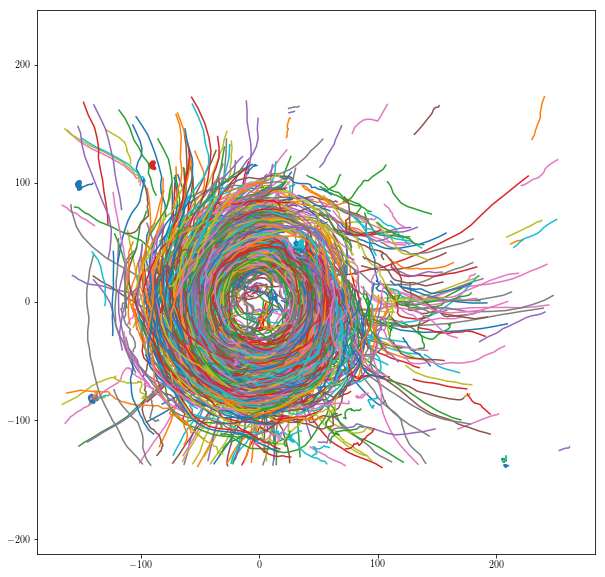

In [66]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.axis('equal')

for p in Trayectories.particle.unique():
    prt_ind = Trayectories.particle==p
    plt.plot(Trayectories[prt_ind].x0,Trayectories[prt_ind].y0)

In [67]:
HTML(AnimateTrayectory(Trayectories).to_html5_video())

# Calculate Velocities

In [68]:
Trayectories['r'] = np.sqrt(Trayectories.x0**2+Trayectories.y0**2)
Trayectories['phi'] = np.arctan2(Trayectories.y0,Trayectories.x0)

Trayectories['vr']=0
Trayectories['omg']=0
Trayectories['vth']=0

Trayectories['vx']=0
Trayectories['vy']=0

for i in Trayectories.particle.unique():
    location = Trayectories.particle==i
    Trayectories.loc[location,'vr'] = np.append(np.diff(Trayectories[location].r),np.NaN)
    Trayectories.loc[location,'omg'] = np.append(np.diff(np.unwrap(Trayectories[location].phi)),np.NaN)
    Trayectories.loc[location,'vx'] = np.append(np.diff(Trayectories[location].x0),np.NaN)
    Trayectories.loc[location,'vy'] = np.append(np.diff(Trayectories[location].y0),np.NaN)
    
Trayectories['vth'] = Trayectories['r']*Trayectories['omg']

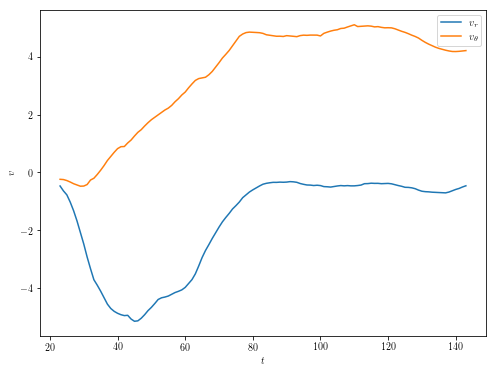

In [69]:
MeanV = (Trayectories.groupby('frame').mean()).rolling(window=10,center=False).mean()

fig, ax1 = plt.subplots(1,1,figsize=[8,6])

ax1.plot(MeanV.index,MeanV.vr);
ax1.plot(MeanV.index,MeanV.vth);

plt.xlabel('$t$')
plt.ylabel('$v$')
plt.legend(['$v_r$','$v_{\\theta}$'])

# Calculate Order Parameters

The order parameters are given by: 
$$P =\left|\frac{\sum_i\vec{v}_i}{\sum_i\left|\vec{v}_i\right|}\right| $$
$$M =\left|\frac{\sum_i\vec{r}_i\times\vec{v}_i}{\sum_i\left|\vec{r}_i\right|\left|\vec{v}_i\right|}\right| $$

$$P =\left|\frac{\sum_i\vec{v}_i}{\sum_i\left|\vec{v}_i\right|}\right| $$

$$P =\left|\frac{\sum_i v^x_i }{\sum_i\left|\vec{v}_i\right|}\hat{x}+\frac{\sum_i v^y_i}{\sum_i\left|\vec{v}_i\right|}\hat{y}\right| $$

$$P =
\sqrt{
\left(\frac{\sum_i v^x_i }{\sum_i\left|\vec{v}_i\right|}\right)^2 +
\left(\frac{\sum_i v^y_i}{\sum_i\left|\vec{v}_i\right|}\right)^2} $$

In [70]:
def CalculateOrderParameters(T):
    T = cp.deepcopy(T)
    
    T['rxv'] = T['vx']*T['y0']-T['vy']*T['x0']

    T['v_mag'] = np.sqrt(T['vx']**2 + T['vy']**2)
    
    T['rxv_mag'] = T['r'] * T['v_mag']

    Order = T.groupby('t').sum();

    Order['M']=np.abs(Order.rxv/Order.rxv_mag)

    Order['P']=np.sqrt((Order.vx/Order.v_mag)**2 + (Order.vy/Order.v_mag)**2)
    Order = Order.filter(["t","M","P"])
    return Order

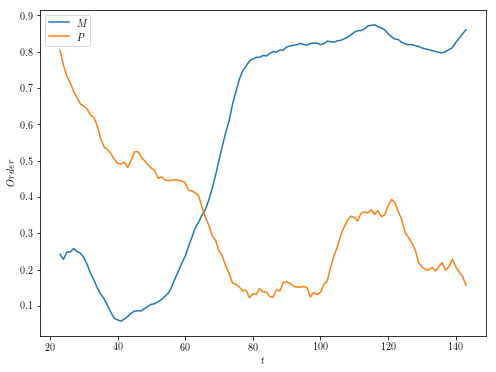

In [73]:
Sum = CalculateOrderParameters(Trayectories).rolling(window=10,center=False).mean()

fig, ax1 = plt.subplots(1,1,figsize=[8,6])

ax1.plot(Sum.index,Sum.M);
ax1.plot(Sum.index,Sum.P);

plt.xlabel('$t$')
plt.ylabel('$Order$')
plt.legend(['$M$','$P$'])

# Support Functions

In [72]:
def AnimateTrayectory(T):
    NumberOfFrames = T.index.max()

    fig, ax = plt.subplots(1,1,figsize=(8,6))
    Points = ax.plot(0,0,'o')
    Center = ax.plot(0,0,'o',color='red')
    plt.xlim([-300,100])
    plt.ylim([-150,200])
    plt.close()

    def init():
        Points[0].set_data([],[])
        Center[0].set_data([], [])
        return (Points,Center)

    def animate(i):
        fr_ind=(T.index==i)
        Points[0].set_data(T[fr_ind].x0,T[fr_ind].y0)
        Center[0].set_data(0,0)
        return (Points,Center)

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                       frames=T.index.unique(), interval=200, blit=False)
    return anim